
<br>
<center>
<font size='7' style="color:#0D47A1">  <b>CHEMICAL GNNs</b> </font>
</center>

<hr style= "height:3px;">
<br>


<hr style= "height:1px;">
<font size='6' style="color:#000000">  <b>Content</b> </font>
<a name="content"></a>
<br>
<br>

1. [Abstract](#abstract) 
<br>

2. [Setup](#setup)
<br>

3. [Loading Data](#loading)
<br>

4. [Explore the Data](#exploration)
<br>

5. [Data Cleaning](#cleaning)
<br>

6. [Feature Selection](#features)
<br>

7. [Results & Discussion](#results)
<br>

8. [Perspectives](#perspectives)
<br>

9. [References](#references)
<br>

<hr style= "height:1px;">

<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>1. Abstract</b> </font>
<a name="setup"></a>

[[ Back to Top ]](#content)
<br>
<br>

<font size='4'>

In this Notebook we studied 3 different strategies for the training of various machine learning models. After comparing and choosing the best training strategy we proceed to evaluate the models with an additional cross validation step. The model performance are reported in with two generic metrics and choose or definition for a better metric for the problem at hand is a work in progress. 

</font> 

<br>
<br>
<font size='5' style="color:#4CAF50">  <b>Purpose</b></font>

<br>
<font size='4'>
    
Obtain the best training strategy for generic ML Model.

</font> 


<br>
<br>


<br>
<br>
<font size='5' style="color:#4CAF50">  <b>Goals</b></font>


 - Find the best training strategy.
 - Define custome metrics for evaluation.
 - Compare several ML models.
 - Obtain statistics of model training with cross validation.
 

<br>
<br>
<font size='5' style="color:#4CAF50">  <b>Methodology/Plan</b></font>

1. Strategy 1.
 - No feature or targe transformation.
2. Strategy 2.
 - Feature transformation.
 - Target transformation.
3. Strategy 3.
 - Feature transformation.
 - Target transformation.
4. Benchmark.
 - Include cross validation in the training process.
 



<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>2. Setup</b> </font>
<a name="setup"></a>

[[ Back to Top ]](#content)
<br>
<br>

The following imports are divided by sections according to their role in the notebook. 



In [ ]:
``` pip install graph_nets matplotlib scipy "tensorflow>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"

In [1]:

# Data Science 
# ==============================================================================
import pandas as pd
import numpy as np
from scipy.stats import gmean


# Sklearn Basic imports
# ==============================================================================
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


!pip install rdkit-pypi
# Rdkit import for molecular features
# ==============================================================================
import rdkit
import rdkit.Chem
import rdkit.Chem.Fragments
import rdkit.Chem.Descriptors
import rdkit.Chem.rdchem



# Ploting 
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:

import networkx as nx
import graph_nets as gn
from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf


In [2]:

pd.set_option("display.precision", 3)


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>3. Loading Data</b> </font>
<a name="loading"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


In [3]:

# Load the raw data
# ==============================================================================
df_raw = pd.read_csv("https://raw.githubusercontent.com/RigelAlgebar/RIIA-CHEMICAL-GNN/master/data/delaney-processed.csv")
df_raw.head()


,Unnamed: 0,Molecular Weight,Polar Surface Area,Number of Rings,Number of Rings.1,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds,measured log solubility in mols per litre
0,1,201.225,42.24,2,2,76,11,4,-3.30
1,2,152.237,17.07,0,0,62,0,3,-2.06
2,4,84.143,0.00,1,1,26,5,0,-1.33
3,6,326.437,0.00,2,2,88,12,1,-7.32
4,7,272.388,40.46,4,4,108,6,1,-5.03


In [4]:

# Quick overview of the data statistics
# ==============================================================================
df_raw.describe()


,Unnamed: 0,Molecular Weight,Polar Surface Area,Number of Rings,Number of Rings.1,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds,measured log solubility in mols per litre
count,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000,1015.000
mean,558.767,195.746,32.144,1.242,1.242,68.536,4.831,1.658,-2.939
std,325.005,93.801,29.465,1.139,1.139,31.774,4.788,1.876,1.963
min,1.000,16.043,0.000,0.000,0.000,8.000,0.000,0.000,-11.600
25%,276.000,118.245,0.000,0.000,0.000,42.000,0.000,0.000,-4.180
50%,556.000,175.000,26.300,1.000,1.000,60.000,6.000,1.000,-2.770
75%,837.500,264.647,52.775,2.000,2.000,92.000,6.000,3.000,-1.595
max,1127.000,505.206,129.420,5.000,5.000,170.000,18.000,9.000,1.580


In [5]:

# We whould never modify the raw external data so here we take the data we need and store it in our own
# dataframe for further analysis
# ==============================================================================
df = df_raw.copy(deep=True)
df.drop(columns=['Unnamed: 0','Number of Rings.1'], inplace=True)
df.head()


,Molecular Weight,Polar Surface Area,Number of Rings,Number of Valence Electrons,Number of Aromatic Atoms,Number of Conjugated Bonds,measured log solubility in mols per litre
0,201.225,42.24,2,76,11,4,-3.30
1,152.237,17.07,0,62,0,3,-2.06
2,84.143,0.00,1,26,5,0,-1.33
3,326.437,0.00,2,88,12,1,-7.32
4,272.388,40.46,4,108,6,1,-5.03


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<font size='6' style="color:#00A6D6">  <b>4. Explore the Data</b> </font>
<a name="exploration"></a>

[[ Back to Top ]](#content)

<br>
<br>
<br>


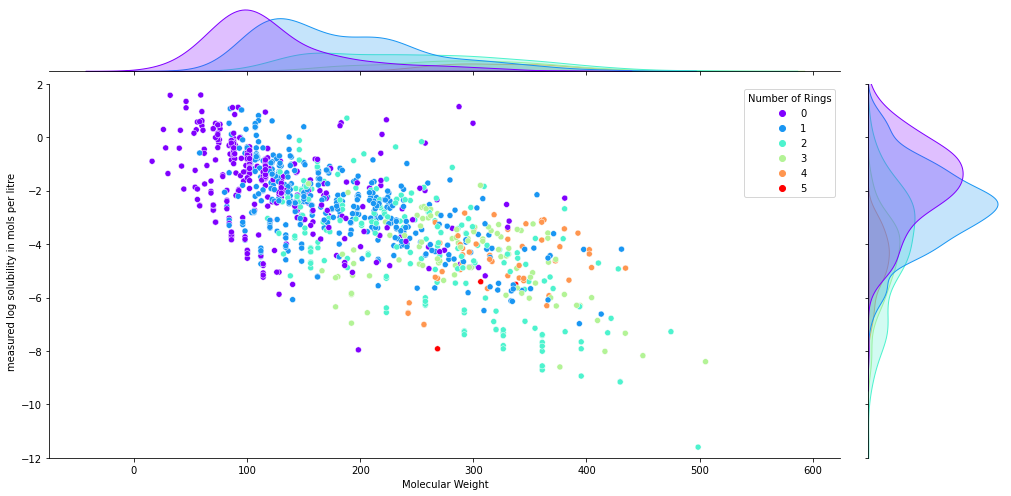

In [11]:

# Here we show the distribution of both the solubility and the molecular weight.
# Both variables grouped by the number of rings in the molecules.
# ==============================================================================
jointplot_mw = sns.jointplot(x='Molecular Weight', y='measured log solubility in mols per litre', 
               hue='Number of Rings', 
               palette='rainbow', height=7,
               data=df)

jointplot_mw.fig.set_figwidth(15)
plt.ylim(-12,2)
plt.show()
